# Writing Kanji with a time distributed MDN-RNN 

- This notebook is the same as the Kanji MDN-RNN except that it trains on predictions made over the whole sequence length.
- The MDN-RNN is also written in Keras' functional API for good measure!


In [1]:
import keras
from context import * # imports the MDN layer 
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline

# Only for GPU use:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

Using TensorFlow backend.


### Download the Dataset:

In [2]:
# Train from David Ha's Kanji dataset from Sketch-RNN: https://github.com/hardmaru/sketch-rnn-datasets
# Other datasets in "Sketch 3" format should also work.
import urllib.request
url = 'https://github.com/hardmaru/sketch-rnn-datasets/raw/master/kanji/kanji.rdp25.npz'  
urllib.request.urlretrieve(url, './kanji.rdp25.npz')  

('./kanji.rdp25.npz', <http.client.HTTPMessage at 0x7feaaa0cfd68>)

### Dataset:

Includes about 11000 handwritten kanji characters divied into training, validation, and testing sets.

For creative purposes, we may not need the validation or testing sets, and can just focus on the training set.

In [3]:
with np.load('./kanji.rdp25.npz') as data:
    train_set = data['train']
    valid_set = data['valid']
    test_set = data['test']
    
print("Training kanji:", len(train_set))
print("Validation kanji:", len(valid_set))
print("Testing kanji:", len(test_set))

Training kanji: 10358
Validation kanji: 600
Testing kanji: 500


### Setup an MDN RNN

In [5]:
# Training Hyperparameters:
SEQ_LEN = 50
BATCH_SIZE = 64
HIDDEN_UNITS = 256
EPOCHS = 100
SEED = 2345  # set random seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
OUTPUT_DIMENSION = 3
NUMBER_MIXTURES = 10

inputs = keras.layers.Input(shape=(SEQ_LEN,OUTPUT_DIMENSION), name='inputs')
lstm1_out = keras.layers.LSTM(HIDDEN_UNITS, name='lstm1', return_sequences=True)(inputs)
lstm2_out = keras.layers.LSTM(HIDDEN_UNITS, name='lstm2', return_sequences=True)(lstm1_out)
mdn_out = keras.layers.TimeDistributed(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES, name='mdn_outputs'), name='td_mdn')(lstm2_out)

model = keras.models.Model(inputs=inputs, outputs=mdn_out)
model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 50, 3)             0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 50, 256)           266240    
_________________________________________________________________
lstm2 (LSTM)                 (None, 50, 256)           525312    
_________________________________________________________________
td_mdn (TimeDistributed)     (None, 50, 70)            17990     
Total params: 809,542
Trainable params: 809,542
Non-trainable params: 0
_________________________________________________________________


## Process the Data and Train the Model

- Chop up the data into slices of the correct length, generate `X` and `y` for the training process.
- Very similar process to the previous RNN examples!
- We end up with 330000 examples - a pretty healthy dataset.

In [6]:
# Functions for slicing up data
def slice_sequence_examples(sequence, num_steps):
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
    return xs

def seq_to_overlapping_format(examples):
    """Takes sequences of seq_len+1 and returns overlapping
    sequences of seq_len."""
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[1:])
    return (xs,ys)

# Prepare training data as X and Y.
slices = []
for seq in train_set:
    slices +=  slice_sequence_examples(seq, SEQ_LEN+1)
X, y = seq_to_overlapping_format(slices)

X = np.array(X)
y = np.array(y)

print("Number of training examples:")
print("X:", X.shape)
print("y:", y.shape)

Number of training examples:
X: (154279, 50, 3)
y: (154279, 50, 3)


In [7]:
# Prepare validation data as X and Y.
slices = []
for seq in valid_set:
    slices +=  slice_sequence_examples(seq, SEQ_LEN+1)
Xval, yval = seq_to_overlapping_format(slices)

Xval = np.array(Xval)
yval = np.array(yval)

print("Number of training examples:")
print("X:", Xval.shape)
print("y:", yval.shape)

Number of training examples:
X: (8928, 50, 3)
y: (8928, 50, 3)


## Do the training!

- We're not going to train in the tutorial!
- These settings take about 220 seconds per epoch, about 6 hours for the whole training run.

In [ ]:
# Fit the model
filepath="kanji_mdnrnn-{epoch:02d}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks = [keras.callbacks.TerminateOnNaN(), checkpoint]

history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks, validation_data=(Xval,yval))
model.save('kanji_mdnrnn_model_time_distributed.h5')  # creates a HDF5 file 'my_model.h5'

Train on 154279 samples, validate on 8928 samples
Epoch 1/100
154279/154279 [==============================] - 243s 2ms/step - loss: 8.7041 - val_loss: 7.5987

Epoch 00001: val_loss improved from inf to 7.59866, saving model to kanji_mdnrnn-01.hdf5
Epoch 2/100
154279/154279 [==============================] - 240s 2ms/step - loss: 5.0588 - val_loss: 5.8436

Epoch 00002: val_loss improved from 7.59866 to 5.84361, saving model to kanji_mdnrnn-02.hdf5
Epoch 3/100
154279/154279 [==============================] - 240s 2ms/step - loss: 3.9247 - val_loss: 2.3722

Epoch 00003: val_loss improved from 5.84361 to 2.37222, saving model to kanji_mdnrnn-03.hdf5
Epoch 4/100
154279/154279 [==============================] - 245s 2ms/step - loss: 3.3032 - val_loss: 5.8524

Epoch 00004: val_loss did not improve from 2.37222
Epoch 5/100
154279/154279 [==============================] - 253s 2ms/step - loss: 3.2713 - val_loss: 2.1632

Epoch 00005: val_loss improved from 2.37222 to 2.16320, saving model to ka

154279/154279 [==============================] - 236s 2ms/step - loss: 1.2457 - val_loss: 2.4447

Epoch 00049: val_loss did not improve from -0.52062
Epoch 50/100
154279/154279 [==============================] - 237s 2ms/step - loss: 1.0052 - val_loss: 0.9708

Epoch 00050: val_loss did not improve from -0.52062
Epoch 51/100
154279/154279 [==============================] - 238s 2ms/step - loss: 0.4609 - val_loss: 0.5001

Epoch 00051: val_loss did not improve from -0.52062
Epoch 52/100
154279/154279 [==============================] - 237s 2ms/step - loss: 0.7965 - val_loss: 1.5023

Epoch 00052: val_loss did not improve from -0.52062
Epoch 53/100
154279/154279 [==============================] - 239s 2ms/step - loss: 0.7049 - val_loss: 3.1625

Epoch 00053: val_loss did not improve from -0.52062
Epoch 54/100
154279/154279 [==============================] - 237s 2ms/step - loss: 0.5464 - val_loss: 1.9972

Epoch 00054: val_loss did not improve from -0.52062
Epoch 55/100
  2624/154279 [.......

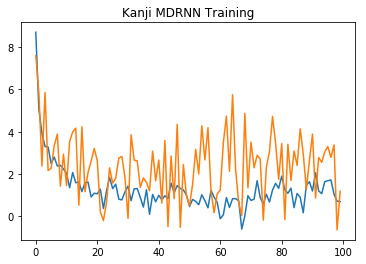

In [118]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Kanji MDRNN Training")
plt.show()

In [50]:
!ls

context.py		    kanji_mdnrnn-17--0.85.hdf5
figures			    kanji_mdnrnn-20--1.29.hdf5
kanji_mdnrnn-01-0.38.hdf5   kanji_mdnrnn-22.hdf5
kanji_mdnrnn-01-4.24.hdf5   kanji_mdnrnn-23.hdf5
kanji_mdnrnn-01.hdf5	    kanji_mdnrnn-44.hdf5
kanji_mdnrnn-02--0.54.hdf5  kanji_mdnrnn-48.hdf5
kanji_mdnrnn-02-1.27.hdf5   kanji_mdnrnn-99.hdf5
kanji_mdnrnn-02.hdf5	    kanji_mdnrnn_model.h5
kanji_mdnrnn-03--0.70.hdf5  kanji_mdnrnn_model_time_distributed.h5
kanji_mdnrnn-03.hdf5	    kanji.rdp25.npz
kanji_mdnrnn-05.hdf5	    MDN-1D-sine-prediction.ipynb
kanji_mdnrnn-06-0.76.hdf5   MDN-2D-spiral-prediction.ipynb
kanji_mdnrnn-06--1.12.hdf5  MDN-RNN-kanji-generation-example.ipynb
kanji_mdnrnn-07-0.50.hdf5   MDN-RNN-RoboJam-touch-generation.ipynb
kanji_mdnrnn-09--0.72.hdf5  MDN-RNN-time-distributed-MDN-training.ipynb
kanji_mdnrnn-09.hdf5	    __pycache__
kanji_mdnrnn-15.hdf5	    sample.svg


## Try out the model! Generate some Kanji!

We need to create a decoding model with batch size 1 and sequence length 1.

In [51]:
# Decoding Model
# Same as training model except for dimension and mixtures.

decoder = keras.Sequential()
decoder.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(1,1,OUTPUT_DIMENSION), return_sequences=True, stateful=True))
decoder.add(keras.layers.LSTM(HIDDEN_UNITS, stateful=True))
decoder.add(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))
decoder.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer=keras.optimizers.Adam())
decoder.summary()

#decoder.load_weights('kanji_mdnrnn_model_time_distributed.h5') # load weights independently from file
decoder.load_weights('kanji_mdnrnn-99.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 1, 256)               266240    
_________________________________________________________________
lstm_4 (LSTM)                (1, 256)                  525312    
_________________________________________________________________
mdn_2 (MDN)                  (1, 70)                   17990     
Total params: 809,542
Trainable params: 809,542
Non-trainable params: 0
_________________________________________________________________


## Generating drawings

- First need some helper functions to view the output.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def zero_start_position():
    """A zeroed out start position with pen down"""
    out = np.zeros((1, 1, 3), dtype=np.float32)
    out[0, 0, 2] = 1 # set pen down.
    return out

def generate_sketch(model, start_pos, num_points=100):
     return None

def cutoff_stroke(x):
    return np.greater(x,0.5) * 1.0

def plot_sketch(sketch_array):
    """Plot a sketch quickly to see what it looks like."""
    sketch_df = pd.DataFrame({'x':sketch_array.T[0],'y':sketch_array.T[1],'z':sketch_array.T[2]})
    sketch_df.x = sketch_df.x.cumsum()
    sketch_df.y = -1 * sketch_df.y.cumsum()
    # Do the plot
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111)
    #ax1.scatter(sketch_df.x,sketch_df.y,marker='o', c='r', alpha=1.0)
    # Need to do something with sketch_df.z
    ax1.plot(sketch_df.x,sketch_df.y,'r-')
    plt.show()

## SVG Drawing Function

Here's Hardmaru's Drawing Functions from _write-rnn-tensorflow_. Big hat tip to Hardmaru for this!

Here's the source: https://github.com/hardmaru/write-rnn-tensorflow/blob/master/utils.py


In [67]:
# Hardmaru's Drawing Functions from write-rnn-tensorflow
# Big hat tip
# Here's the source:
# https://github.com/hardmaru/write-rnn-tensorflow/blob/master/utils.py

import svgwrite
from IPython.display import SVG, display

def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)

def draw_strokes(data, factor=1, svg_filename='sample.svg'):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1

    abs_x = 25 - min_x
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)

    command = "m"

    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        lift_pen = data[i, 2]
        p += command + str(x) + "," + str(y) + " "

    the_color = "black"
    stroke_width = 2

    dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))

    dwg.save()
    display(SVG(dwg.tostring()))

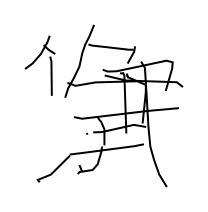

In [117]:
# Predict a character and plot the result.
temperature = 2 # seems to work well with rather high temperature (2.5)

p = zero_start_position()
sketch = [p.reshape(3,)]

for i in range(100):
    params = decoder.predict(p.reshape(1,1,3))
    p = mdn.sample_from_output(params[0], OUTPUT_DIMENSION, NUMBER_MIXTURES, temp=temperature)
    sketch.append(p.reshape((3,)))

sketch = np.array(sketch)
decoder.reset_states()

sketch.T[2] = cutoff_stroke(sketch.T[2])
draw_strokes(sketch, factor=0.5)
#plot_sketch(sketch)